# **Project 10 - Clustering**

**Importing the necessary packages**

In [63]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [64]:
df = pd.read_csv('dataset.csv')

In [65]:
print("Shape is:", df.shape)
display(df.head())

print("\nColumns:")
print(df.columns.tolist())

for col in ['genre', 'genres', 'Genre', 'Genres']:
    if col in df.columns:
        print(f"\nTop genres in column '{col}':")
        display(df[col].value_counts().head(10))

Shape is: (114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic



Columns:
['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']


**Creating metadata dataframe**

In [66]:
metadata_cols = [
    'Unnamed: 0',
    'track_id',
    'artists',
    'album_name',
    'track_name']
metadata_df = df[metadata_cols].copy()

In [67]:
features_df = df.drop(columns=metadata_cols).copy()

print("Features shape is:", features_df.shape)
features_df.head()

Features shape is: (114000, 16)


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [68]:
features_df.dtypes

,0
popularity,int64
duration_ms,int64
explicit,bool
danceability,float64
energy,float64
key,int64
loudness,float64
mode,int64
speechiness,float64
acousticness,float64


I removed the metadata of the tracks (Number, Track Id, Artists, Album Name, Track Name) and stored them in a separate dataframe, as they are not involved in the clustering process. In this way, the resulting dataframe includes only the musical characteristics and genre of each track.

**Applying one-hot encoding**

In [69]:
genre_col = ['track_genre']
numeric_cols = features_df.drop(columns=genre_col).columns.tolist()

In [70]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore'
)

genre_encoded = ohe.fit_transform(features_df[genre_col])

genre_encoded_df = pd.DataFrame(
    genre_encoded,
    columns=ohe.get_feature_names_out(genre_col),
    index=features_df.index)

In [71]:
features_ohe_df = pd.concat(
    [features_df[numeric_cols], genre_encoded_df],
    axis=1
)

print("The shape after one-hot encoding is:", features_ohe_df.shape)
features_ohe_df.head()

The shape after one-hot encoding is: (114000, 129)


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After applying the one-hot encoding to the track_genre variable, we have in the final dataset 129 features. Now genres are represented as binary variables.

**Normalization**

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(features_ohe_df)

print("Scaled shape now is:", X_scaled.shape)

Scaled shape now is: (114000, 129)


In [73]:
k_values = [2, 3, 5, 7, 10, 15, 20]
sse = []

In [74]:
from sklearn.cluster import KMeans

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )

    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

    print(f"k={k}, SSE={kmeans.inertia_:.2f}")

k=2, SSE=14423469.60
k=3, SSE=14272096.80
k=5, SSE=14016358.57
k=7, SSE=13754396.97
k=10, SSE=13370978.96
k=15, SSE=12773647.17
k=20, SSE=12188704.40


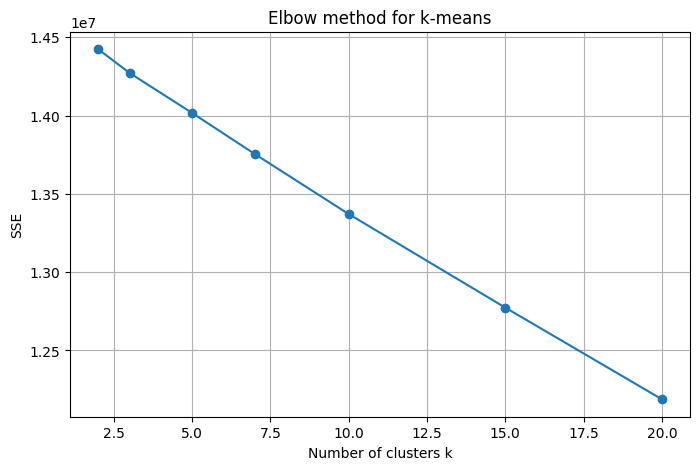

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('SSE')
plt.title('Elbow method for k-means')
plt.grid(True)
plt.show()

I applied the elbow method to select the number of clusters, calculating the SSE metric for different values of k. From the diagram above, we can see that after k = 10, the reduction in SSE becomes less pronounced. Therefore, I chose k = 10 as a satisfactory number of groups that achieves a good balance between simplicity and clustering quality.

In [76]:
k_opt = 10

kmeans_final = KMeans(
    n_clusters=k_opt,
    random_state=42,
    n_init=10
)
labels = kmeans_final.fit_predict(X_scaled)

In [77]:
features_df['cluster'] = labels
metadata_df['cluster'] = labels

In [78]:
features_df['cluster'].value_counts().sort_index()

,count
cluster,
0,6445
1,16575
2,16847
3,8034
4,12940
5,19243
6,10974
7,14062
8,1000


As we can observe from above, the distribution of music tracks across clusters varies in terms of group size, which is to be expected in kmeans. Most clusters include a large number of tracks, while there is also a smaller cluster (8th), which probably corresponds to more specialized musical characteristics.

In [79]:
cluster_genre_dist = (
    features_df
    .groupby('cluster')['track_genre']
    .value_counts(normalize=True)
    .rename('percentage')
    .reset_index())

In [80]:
dominant_genre = (
    cluster_genre_dist
    .sort_values(['cluster', 'percentage'], ascending=[True, False])
    .groupby('cluster')
    .first()
    .reset_index()
)

dominant_genre

,cluster,track_genre,percentage
0,0,death-metal,0.155159
1,1,alt-rock,0.060332
2,2,cantopop,0.059358
3,3,sleep,0.124347
4,4,deep-house,0.077280
5,5,dub,0.051967
6,6,country,0.091124
7,7,alternative,0.071114
8,8,comedy,1.000000
9,9,breakbeat,0.126904


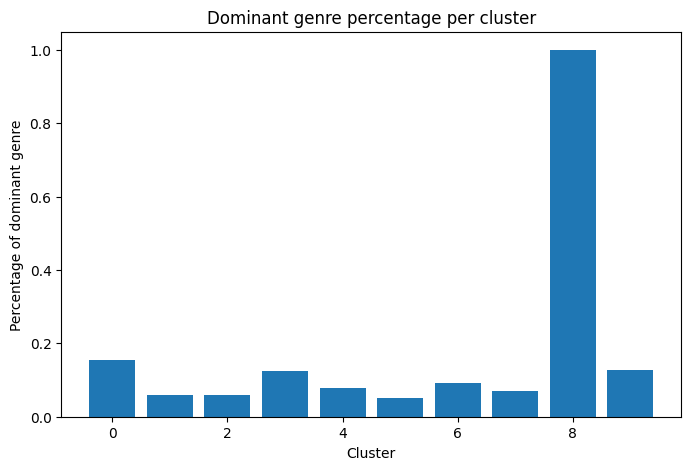

In [81]:
plt.figure(figsize=(8, 5))
plt.bar(
    dominant_genre['cluster'],
    dominant_genre['percentage']
)

plt.xlabel('Cluster')
plt.ylabel('Percentage of dominant genre')
plt.title('Dominant genre percentage per cluster')
plt.show()

As we can clearly observe from above,most clusters have low percentages of dominant genres, suggesting that the grouping is based mainly on the acoustic characteristics of the tracks and not exclusively on genre. However, we can see that clusetr 8 is the exception and that it consists solely of comedy tracks. This shows that this genre has a clearly distinct musical profile.

**Choosing a song I like**

In [82]:
metadata_df[metadata_df['artists'].str.contains('Katy Perry', case=False, na=False)].head()

,Unnamed: 0,track_id,artists,album_name,track_name,cluster
19550,19550,2yBWKK84uebv35lGajIMhc,Thomas Rhett;Katy Perry,Where We Started,Where We Started,6
20002,20002,5nCthAh3jt4xKuLJAifAaR,Katy Perry,Harleys In Hawaii,Harleys In Hawaii,7
20058,20058,3B4etxytImrRKQgV3XHjnR,Katy Perry,Smile,Harleys In Hawaii,7
20212,20212,5kihSsgmpiecsJjjKI80QR,Katy Perry,Workout Hits 2023,I Kissed A Girl,7
20214,20214,06frz7np2mUzt0wUTBERYP,Katy Perry,Rock Christmas 2022 - The Very Best Of,Cozy Little Christmas,7


In [83]:
song_title = "Harleys In Hawaii"
artist_name = "Katy Perry"

song_idx = metadata_df[
    (metadata_df['track_name'].str.lower() == song_title.lower()) &
    (metadata_df['artists'].str.contains(artist_name, case=False, na=False))
].index[0]

song_idx

np.int64(20002)

In [84]:
selected_song = metadata_df.loc[song_idx]
selected_cluster = selected_song['cluster']

selected_song, selected_cluster

(Unnamed: 0                     20002
 track_id      5nCthAh3jt4xKuLJAifAaR
 artists                   Katy Perry
 album_name         Harleys In Hawaii
 track_name         Harleys In Hawaii
 cluster                            7
 Name: 20002, dtype: object,
 np.int32(7))

In [85]:
cluster_indices = metadata_df[
    metadata_df['cluster'] == selected_cluster
].index

In [86]:
from sklearn.metrics import pairwise_distances

distances = pairwise_distances(
    X_scaled[cluster_indices],
    X_scaled[song_idx].reshape(1, -1),
    metric='euclidean'
).flatten()

In [87]:
distance_df = pd.DataFrame({
    'index': cluster_indices,
    'distance': distances
})

top3 = (
    distance_df
    .sort_values('distance')
    .iloc[1:5]
)

recommendations = metadata_df.loc[top3['index']]
recommendations


,Unnamed: 0,track_id,artists,album_name,track_name,cluster
20058,20058,3B4etxytImrRKQgV3XHjnR,Katy Perry,Smile,Harleys In Hawaii,7
20420,20420,2Cd9iWfcOpGDHLz6tVA3G4,Shakira;Freshlyground,Waka Waka (This Time for Africa) [The Official...,Waka Waka (This Time for Africa) [The Official...,7
20855,20855,6WrI0LAC5M1Rw2MnX2ZvEg,Dua Lipa,Don't Start Now,Don't Start Now,7
20707,20707,3PfIrDoz19wz7qK7tYeu62,Dua Lipa,Future Nostalgia,Don't Start Now,7


In [88]:
song_title = "Harleys In Hawaii"
artist_name = "Katy Perry"

matches = metadata_df[
    (metadata_df['track_name'].str.lower() == song_title.lower()) &
    (metadata_df['artists'].str.contains(artist_name, case=False, na=False))
]

print("number of rows:", len(matches))
matches[['track_id','artists','album_name','track_name','cluster']].head(20)

number of rows: 4


,track_id,artists,album_name,track_name,cluster
20002,5nCthAh3jt4xKuLJAifAaR,Katy Perry,Harleys In Hawaii,Harleys In Hawaii,7
20058,3B4etxytImrRKQgV3XHjnR,Katy Perry,Smile,Harleys In Hawaii,7
81350,5nCthAh3jt4xKuLJAifAaR,Katy Perry,Harleys In Hawaii,Harleys In Hawaii,1
81360,3B4etxytImrRKQgV3XHjnR,Katy Perry,Smile,Harleys In Hawaii,1


From the above I got the curiosity of how many times the same song appears in the dataset and I see that it exists 4 times already. It has to be why it is corresponding to different versions (e.g., single and album). Also, the different recordings may belong to different clusters, due to variations in acoustic characteristics.

Whatsoever, I chose Katy Perry's song Harleys In Hawaii, which belongs to cluster 7. To find similar songs, I calculated the Euclidean distance between the selected track and the other tracks in the same cluster. The songs Waka Waka (This Time for Africa) by Shakira and Don't Start Now by Dua Lipa, which have similar musical characteristics, were selected as the top three suggestions. In my opinion, the suggestions are relevant to the original track.

In [89]:
song_idx = 20002
selected_cluster = metadata_df.loc[song_idx, 'cluster']

In [90]:
cluster_indices = metadata_df[
    metadata_df['cluster'] == selected_cluster
].index

In [91]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(
    X_scaled[cluster_indices],
    X_scaled[song_idx].reshape(1, -1)
).flatten()

cosine_distances = 1 - similarities

In [92]:
selected_track_id = metadata_df.loc[song_idx, 'track_id']

distance_df = pd.DataFrame({
    'index': cluster_indices,
    'distance': cosine_distances
})
mask = (metadata_df.loc[distance_df['index'], 'track_id'].values != selected_track_id)
distance_df = distance_df[mask]

In [93]:
top3_cosine = (
    distance_df
    .sort_values('distance')
    .head(3)
)

recommendations_cosine = metadata_df.loc[top3_cosine['index']]
recommendations_cosine

,Unnamed: 0,track_id,artists,album_name,track_name,cluster
20058,20058,3B4etxytImrRKQgV3XHjnR,Katy Perry,Smile,Harleys In Hawaii,7
20420,20420,2Cd9iWfcOpGDHLz6tVA3G4,Shakira;Freshlyground,Waka Waka (This Time for Africa) [The Official...,Waka Waka (This Time for Africa) [The Official...,7
20855,20855,6WrI0LAC5M1Rw2MnX2ZvEg,Dua Lipa,Don't Start Now,Don't Start Now,7


As we can see from above, we got the same answers as before. More specifically, I repeted the question 6 using Cosine Distance (1 − Cosine Similarity) as the distance metric. For the selected song, the Top-3 recommendations were the same as those of Euclidean distance. Therefore, in this case, Cosine Distance did not provide significantly better recommendations, but rather equivalent ones.

**Now using k = 7**

In [94]:
from sklearn.cluster import KMeans

k_alt = 7

kmeans_7 = KMeans(
    n_clusters=k_alt,
    random_state=42,
    n_init=10
)

labels_7 = kmeans_7.fit_predict(X_scaled)

In [95]:
features_df['cluster_7'] = labels_7
metadata_df['cluster_7'] = labels_7

In [96]:
features_df['cluster_7'].value_counts().sort_index()

,count
cluster_7,
0,15369
1,25299
2,6960
3,31081
4,17802
5,3005
6,14484


From above we can observe that the distribution of tracks across the seven clusters is uneven, with clusters 3 and 1 containing the largest number of songs, while cluster 5 is significantly smaller. This imbalance could suggest that some musical profiles are more common in the dataset, whereas others represent more specialized or less frequent audio characteristics.

In [97]:
cluster_genre_dist_7 = (
    features_df
    .groupby('cluster_7')['track_genre']
    .value_counts(normalize=True)
    .rename('percentage')
    .reset_index()
)

dominant_genre_7 = (
    cluster_genre_dist_7
    .sort_values(['cluster_7', 'percentage'], ascending=[True, False])
    .groupby('cluster_7')
    .first()
    .reset_index()
)

dominant_genre_7

,cluster_7,track_genre,percentage
0,0,death-metal,0.065066
1,1,dance,0.039527
2,2,chicago-house,0.143678
3,3,forro,0.032174
4,4,brazil,0.056173
5,5,comedy,0.332779
6,6,sleep,0.068904


We see that in most clusters, the dominant genre represents only a small part of the songs, which means that each cluster includes many different music styles. However, cluster 5 is different, as the comedy genre appears much more often, showing that this cluster is more uniform.

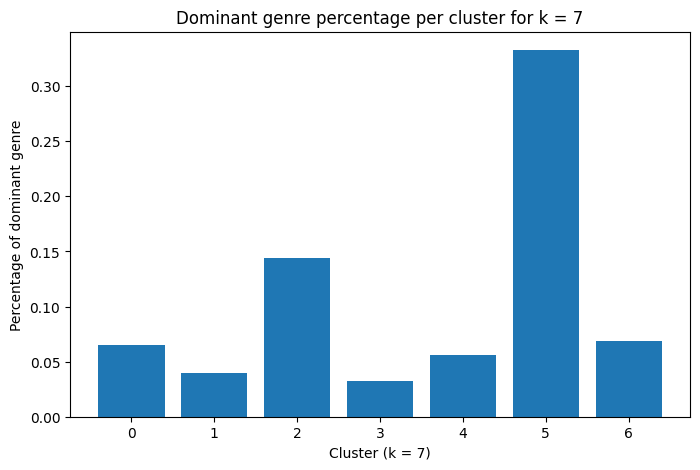

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(
    dominant_genre_7['cluster_7'],
    dominant_genre_7['percentage']
)

plt.xlabel('Cluster (k = 7)')
plt.ylabel('Percentage of dominant genre')
plt.title('Dominant genre percentage per cluster for k = 7')
plt.show()

Here as before we can see that the bar chart shows that most clusters have a low dominant genre percentage, meaning they contain a mix of different music styles. Cluster 5 stands out with a much higher percentage, indicating that it is more consistent and focused on a specific type of music.

In [99]:
song_idx = 20002
selected_cluster_7 = metadata_df.loc[song_idx, 'cluster_7']

In [100]:
cluster_indices_7 = metadata_df[
    metadata_df['cluster_7'] == selected_cluster_7
].index

In [101]:
from sklearn.metrics import pairwise_distances
import pandas as pd

distances_7 = pairwise_distances(
    X_scaled[cluster_indices_7],
    X_scaled[song_idx].reshape(1, -1),
    metric='euclidean'
).flatten()

selected_track_id = metadata_df.loc[song_idx, 'track_id']

distance_df_7 = pd.DataFrame({
    'index': cluster_indices_7,
    'distance': distances_7
})

mask = (
    metadata_df.loc[distance_df_7['index'], 'track_id'].values
    != selected_track_id
)

distance_df_7 = distance_df_7[mask]

top3_euclidean_7 = distance_df_7.sort_values('distance').head(3)
recommendations_euclidean_7 = metadata_df.loc[top3_euclidean_7['index']]

recommendations_euclidean_7

,Unnamed: 0,track_id,artists,album_name,track_name,cluster,cluster_7
20058,20058,3B4etxytImrRKQgV3XHjnR,Katy Perry,Smile,Harleys In Hawaii,7,1
20420,20420,2Cd9iWfcOpGDHLz6tVA3G4,Shakira;Freshlyground,Waka Waka (This Time for Africa) [The Official...,Waka Waka (This Time for Africa) [The Official...,7,1
20855,20855,6WrI0LAC5M1Rw2MnX2ZvEg,Dua Lipa,Don't Start Now,Don't Start Now,7,1


That is a very interesting discovery, that the recommended songs are exactly the same as those obtained when using k = 10. This shows that changing the number of clusters did not affect the recommendations for this song.

In [102]:
from sklearn.metrics.pairwise import cosine_similarity

similarities_7 = cosine_similarity(
    X_scaled[cluster_indices_7],
    X_scaled[song_idx].reshape(1, -1)
).flatten()

cosine_distances_7 = 1 - similarities_7

distance_df_cosine_7 = pd.DataFrame({
    'index': cluster_indices_7,
    'distance': cosine_distances_7
})

mask = (
    metadata_df.loc[distance_df_cosine_7['index'], 'track_id'].values
    != selected_track_id
)

distance_df_cosine_7 = distance_df_cosine_7[mask]

top3_cosine_7 = distance_df_cosine_7.sort_values('distance').head(3)
recommendations_cosine_7 = metadata_df.loc[top3_cosine_7['index']]

recommendations_cosine_7

,Unnamed: 0,track_id,artists,album_name,track_name,cluster,cluster_7
20058,20058,3B4etxytImrRKQgV3XHjnR,Katy Perry,Smile,Harleys In Hawaii,7,1
20420,20420,2Cd9iWfcOpGDHLz6tVA3G4,Shakira;Freshlyground,Waka Waka (This Time for Africa) [The Official...,Waka Waka (This Time for Africa) [The Official...,7,1
20855,20855,6WrI0LAC5M1Rw2MnX2ZvEg,Dua Lipa,Don't Start Now,Don't Start Now,7,1


The cosine distance shows us exactly the same song recommendations as before. This means that using cosine distance did not change the results compared to Euclidean distance for this case.

**Applying HDBSCAN**

In [103]:
import numpy as np
from sklearn.cluster import DBSCAN

np.random.seed(42)

sample_size = 5000
sample_idx = np.random.choice(X_scaled.shape[0], size=sample_size, replace=False)
X_sample = X_scaled[sample_idx]

db = DBSCAN(eps=3.0, min_samples=10, n_jobs=-1)
labels = db.fit_predict(X_sample)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = int((labels == -1).sum())

print("clusters:", n_clusters)
print("noise:", n_noise)
print("noise%:", round(100 * n_noise / sample_size, 2))

clusters: 106
noise: 2018
noise%: 40.36
clusters: 106
noise: 2018
noise%: 40.36


Using DBSCAN, the algorithm detected a much larger number of clusters (106) compared to kmeans with k = 7 and k = 10. In addition, a large percentage of songs were labeled as noise, showing that DBSCAN forms many small clusters and treats many points as outliers.